<a href="https://colab.research.google.com/github/s-thandri/labelflipping/blob/main/german_credit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Imports some of the libraries that we will be using
import pandas as pd
import numpy as np
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')


In [2]:
#This function is being used to calculate the statistical parity of the data set
#test_data: The original data frame containing the test data
#predictors: List of the all the column names AKA IV's
#prediction_df: Contains the predicitons made by the DT model
#sensitive_attr: Name of the sensitive attr
#sensitive_attr_cutoff: Cut off value for sensitive attr
#concat_col: Name of column I am creating new dataframe on
def s_parity(test_data, predictors, prediction_df, sensitive_attr, sensitive_attr_cutoff, concat_col):
    #Creating a new DF that contains all the datapoints from the test data and the predictions made from LR model
    #Concat_col: credit_risk_12
    test_demo_df = pd.DataFrame(test_data, columns = predictors)
    predicted_df = pd.DataFrame(prediction_df, columns = [concat_col])
    concat_df = pd.concat([test_demo_df,predicted_df], axis=1)

    #Get the two groups of people totals
    total_unpriv = (len(concat_df[concat_df[sensitive_attr]<sensitive_attr_cutoff]))
    total_priv = (len(concat_df[concat_df[sensitive_attr]>=sensitive_attr_cutoff]))

    #Number of people accepted
    total_credit_unpriv = len(concat_df[(concat_df[concat_col] == 1) & (concat_df[sensitive_attr] < sensitive_attr_cutoff)])
    total_credit_priv = len(concat_df[(concat_df[concat_col] == 1) & (concat_df[sensitive_attr] >= sensitive_attr_cutoff)])

    #Percentage of approved people
    p_unpriv = total_credit_unpriv/total_unpriv
    p_priv = total_credit_priv/total_priv


    #Calculate the parity
    parity = p_priv - p_unpriv


    return parity

In [3]:
#Make changes to make more efficient
#Function used to run the DT model
#train_dataset: Training dataset to train the model
#independent_var: Column names
#dependent_var: Prediction column name
#concat_col: Name of column creating new DF on
def decision_tree(train_dataset, independent_var, dependent_var, concat_col):
        #Split the data up into train and test values and then run the DT model
        #These steps aren't neccessary to consistenly do over and over again
        x = train_dataset[independent_var].values
        y = train_dataset[dependent_var].values
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=622)
        clf = DecisionTreeClassifier(criterion = 'entropy',max_depth = 3, min_samples_leaf=5)
        log = clf.fit(x_train,y_train)
        prediction = log.predict(x_test)

        #Printing the Overall accuracy of the model after one run
        #F1_Score=metrics.f1_score(y_test, prediction, average='weighted')
        #file.write(f'\nAccuracy of the model on Testing Sample Data: {F1_Score}')

        #Prints out the average across all ten run throughs
        #Accuracy_Values=cross_val_score(log, x , y, cv=10, scoring='f1_weighted')

        accuracy = accuracy_score(y_test,prediction)*100

        #After running the model I return a df with the datapoints and the labels
        test_demo_df = pd.DataFrame(x_test, columns = independent_var)
        #Concat_col: credit_risk_12
        predicted_df = pd.DataFrame(prediction, columns = [concat_col])

        return accuracy, test_demo_df, predicted_df

In [4]:
#Defining the columns and creating the Dataframe with all 1000 datapoints
columns = ["checking_account_status", "duration", "credit_history", "purpose", "credit_amount", "savings_account_status", "employment_status", "installment_rate", "personal_status", "other_debtors", "residence_since", "property", "age", "other_installment_plans", "housing", "existing_credits", "job", "num_dependents", "telephone", "foreign_worker", "credit_risk"]
german_df = pd.read_table('german.data', header = None, delim_whitespace=True, names = columns)

In [5]:
for column in german_df.columns:
    most_common = german_df[column].value_counts().idxmax()
    count = german_df[column].value_counts().max()
    print(f'Most common value in {column}: {most_common}, Count: {count}')

Most common value in checking_account_status: A14, Count: 394
Most common value in duration: 24, Count: 184
Most common value in credit_history: A32, Count: 530
Most common value in purpose: A43, Count: 280
Most common value in credit_amount: 1478, Count: 3
Most common value in savings_account_status: A61, Count: 603
Most common value in employment_status: A73, Count: 339
Most common value in installment_rate: 4, Count: 476
Most common value in personal_status: A93, Count: 548
Most common value in other_debtors: A101, Count: 907
Most common value in residence_since: 4, Count: 413
Most common value in property: A123, Count: 332
Most common value in age: 27, Count: 51
Most common value in other_installment_plans: A143, Count: 814
Most common value in housing: A152, Count: 713
Most common value in existing_credits: 1, Count: 633
Most common value in job: A173, Count: 630
Most common value in num_dependents: 1, Count: 845
Most common value in telephone: A191, Count: 596
Most common value i

In [6]:
#Encode all the non-numeric columns with dummies
encoded_data=pd.get_dummies(german_df,columns=['checking_account_status','credit_history','savings_account_status','employment_status','personal_status','other_debtors','property','other_installment_plans','housing','job','telephone','foreign_worker','purpose'], drop_first=True)

In [7]:
#Initialize all the different columns including predictors and target variable
encoded_data.columns
target_var = 'credit_risk'
predictors = ['duration', 'credit_amount', 'installment_rate',
       'residence_since', 'age', 'existing_credits', 'num_dependents',
       'checking_account_status_A12',
       'checking_account_status_A13', 'checking_account_status_A14',
       'credit_history_A31', 'credit_history_A32', 'credit_history_A33',
       'credit_history_A34', 'savings_account_status_A62',
       'savings_account_status_A63', 'savings_account_status_A64',
       'savings_account_status_A65', 'employment_status_A72',
       'employment_status_A73', 'employment_status_A74',
       'employment_status_A75', 'personal_status_A92', 'personal_status_A93',
       'personal_status_A94', 'other_debtors_A102', 'other_debtors_A103',
       'property_A122', 'property_A123', 'property_A124',
       'other_installment_plans_A142', 'other_installment_plans_A143',
       'housing_A152', 'housing_A153', 'job_A172', 'job_A173', 'job_A174',
       'telephone_A192', 'foreign_worker_A202']


In [8]:
#Setting the columns to each part of the decision tree
#x conatins the IV's
#y contains the DV
x = encoded_data[predictors].values
y = encoded_data[target_var].values

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=622)
#X-train is all the data points for training
#y_train contains the labels for each of the training data points
#x_test contains all the testing data points
#y_test contains the ground truth for each of the test data points

In [10]:
#Run the DT classifier
clf = DecisionTreeClassifier(criterion = 'entropy', max_depth = 3, min_samples_leaf=5)
dt = clf.fit(x_train,y_train)
prediction = dt.predict(x_test)

In [12]:
#Test to see the feature importance
#Implement features importance to see the effect that each one has
feat_dict = {}
for col, val in sorted(zip(predictors, dt.feature_importances_),key=lambda x:x[1],reverse=True):
  feat_dict[col]=val

In [13]:
#Convert the values to a dataframe
feat_df = pd.DataFrame({'Feature':feat_dict.keys(),'Importance':feat_dict.values()})

In [14]:
#Print the dataframe
feat_df

,Feature,Importance
0,checking_account_status_A14,0.511706
1,duration,0.303330
2,age,0.105142
3,other_installment_plans_A143,0.079822
4,credit_amount,0.000000
5,installment_rate,0.000000
6,residence_since,0.000000
7,existing_credits,0.000000
8,num_dependents,0.000000
9,checking_account_status_A12,0.000000


In [16]:
# 1 is good and 2 is bad
dt.classes_

array([1, 2])

In [17]:
#Break the test dataframe into different groups
#Unprotected group is everyone <45
#Complement group is everyone >= 45
test_demo_df = pd.DataFrame(x_test, columns = predictors)
predicted_df = pd.DataFrame(prediction, columns = ['credit_risk_12'])
concat_df = pd.concat([test_demo_df,predicted_df], axis=1)

#Get the two groups of people totals
total_unpriv = (len(concat_df[concat_df['age']<45]))
total_priv = (len(concat_df[concat_df['age']>=45]))

#Number of people accepted
total_credit_unpriv = len(concat_df[(concat_df['credit_risk_12'] == 1) & (concat_df['age'] < 45)])
total_credit_priv = len(concat_df[(concat_df['credit_risk_12'] == 1) & (concat_df['age'] >= 45)])

#Percentage of approved people
p_unpriv = total_credit_unpriv/total_unpriv
p_priv = total_credit_priv/total_priv

statistical_parity = p_priv - p_unpriv
print(f'Statistical Parity: {statistical_parity:.5f}')


Statistical Parity: -0.00717


In [18]:
print(total_unpriv)
print(total_priv)

161
39


In [19]:
#Combine x_train and y_train
#I combine these so that when I flip the labels I have one DF that I work with
#Rather than 2 numpy.ndarrays
train_demo_df = pd.DataFrame(x_train, columns = predictors)
train_outcome_df = pd.DataFrame(y_train, columns = ['credit_risk'])
train_full_df = pd.concat([train_demo_df, train_outcome_df], axis=1)



In [20]:
#When flipping the label make sure convert the flip before into its original value

#Combine x_train and y_train
#Retrain the model after combining them and then flip and calculate
#Implement label flipping and recalculate

#Each list holds a different value

#list_parity holds each parity value after each flip and recalculation
list_parity = []
#list_acc holds the accuracy of each iteration after a flip
list_acc = []
#list_flip holds the row number of the flip; starts at 0 and goes through the whole
list_flip = []

#Iterating through the training dataset
for index, row in train_full_df.iterrows():
  #If the row that I am on has the label 1 (credit_risk is the label name) then I will flip it
  #And then run the decision_tree function to get the accuracy, the DF that contains datapoints,
  #And the DF that contains the predictions
  #The two DF's are then combined in the s_parity function to calculate parity
    if row['credit_risk'] == 1:
      #Flip the label
        train_full_df.at[index, 'credit_risk'] = 2

        #Run the decision tree function
        #train_full_df: training dataset
        #predictors: IV's
        #target_var: DV's
        #'credit_risk12': this is the column that the labels for the test_prediction is in
        accuracy,test_datapoints, test_prediction = decision_tree(train_full_df, predictors, target_var, 'credit_risk_12')

        #list_flip: contains the row number that has just been flipped
        #list_num: contains the accuracy value just calculated
        list_flip.append(index)
        list_acc.append(accuracy)

        ##################################################################################
        #After calculating the accuracy parity calculation is next
        parity = s_parity(test_datapoints, predictors, test_prediction, 'age', 45, 'credit_risk_12')
        #list_parity: contains the parity value after the flip
        list_parity.append(parity)

        #Flips the label back to its original value
        train_full_df.at[index,'credit_risk'] = 1

    #Repeats all the same steps as above but this time if the original label is 2
    elif row['credit_risk'] == 2:
        train_full_df.at[index, 'credit_risk'] = 1

        accuracy,test_datapoints, test_prediction = decision_tree(train_full_df, predictors, target_var, 'credit_risk_12')
        list_flip.append(index)
        list_acc.append(accuracy)

        ##################################################################################
        parity = s_parity(test_datapoints, predictors, test_prediction, 'age', 45, 'credit_risk_12')
        list_parity.append(parity)

        train_full_df.at[index,'credit_risk'] = 2






In [21]:
#parity_difference: Contains the difference between flipped and original value
parity_difference = []
#Contains parity values that fall between .03 and -.03
large_influence = []
#Contains the row number of each flip
li_row = []

#Takes each of the parity values after flipping and compares it to the original parity value
#Appends the difference to a new list
for value in list_parity:
    difference = abs(value) - abs(statistical_parity)
    parity_difference.append(difference)


#Rows are considered to be high influence if they fall in between .03, -.03
for index, item in enumerate(parity_difference):
    if item <= statistical_parity or item >= -statistical_parity:
        large_influence.append(item)
        li_row.append(index)

In [22]:
#Ranking the values that have been appended to the large_influence list
zip_lists = list(zip(large_influence, li_row))

#Sort the list of tuples based on the absolute value of the values
sorted_pairs = sorted(zip_lists, key=lambda pair: pair[0], reverse=True)

#Separate the sorted values and indices back into separate lists
sorted_values, sorted_indices = zip(*sorted_pairs)

In [23]:
#After ranking the values it is time to now go back through the flipping process but flip the top 500 labels based on their ranking
#Parity values after each flip
ranked_parity = []
#Accuracy after every flip
ranked_acc = []
#Index/row of the flip
ranked_flip = []

row_num = 0
#sorted_indices is a tuple so it's coverted to a list
ranked_indices_list = list(sorted_indices)

#Iterate through the ranked indices and start flipping labels based on their position in the list
for row in range(len(ranked_indices_list)):
  #row_num: contains the row number with respect to the dataframe
  row_num = ranked_indices_list[row]
  #If the label at the specific row is 1 it flips it to 2 then calculates the parity and accuracy
  #It follows the same steps as the flipping before
  if train_full_df.at[row_num,'credit_risk'] == 1:
      train_full_df.at[row_num, 'credit_risk'] = 2

      accuracy,test_datapoints, test_prediction = decision_tree(train_full_df, predictors, target_var, 'credit_risk_12')

      ranked_flip.append(row_num)
      ranked_acc.append(accuracy)

      ##################################################################################
      parity = s_parity(test_datapoints, predictors, test_prediction, 'age', 45, 'credit_risk_12')
      ranked_parity.append(parity)

      #train_full_df.at[index,'credit_risk'] = 1

  elif train_full_df.at[row_num,'credit_risk'] == 2:
      train_full_df.at[row_num, 'credit_risk'] = 1

      accuracy,test_datapoints, test_prediction = decision_tree(train_full_df, predictors, target_var, 'credit_risk_12')

      ranked_flip.append(row_num)
      ranked_acc.append(accuracy)

      ##################################################################################
      parity = s_parity(test_datapoints, predictors, test_prediction, 'age', 45, 'credit_risk_12')
      ranked_parity.append(parity)

      #train_full_df.at[index,'credit_risk'] = 2




In [24]:
#Check to see which parity values are less than the original value based on the magnitude
similar_values_df = pd.DataFrame(columns=columns)
similar_values_encoded_data=pd.get_dummies(similar_values_df,columns=['checking_account_status','credit_history','savings_account_status','employment_status','personal_status','other_debtors','property','other_installment_plans','housing','job','telephone','foreign_worker','purpose'], drop_first=True)
for value in range(len(ranked_parity)):
    if abs(ranked_parity[value]) < abs(statistical_parity):
        row = train_full_df.iloc[ranked_flip[value]]
        similar_values_encoded_data = similar_values_encoded_data.append(row, ignore_index=True)



In [26]:
#Count the most common calues in each column
for column in similar_values_encoded_data.columns:
    most_common = similar_values_encoded_data[column].value_counts().idxmax()
    count = similar_values_encoded_data[column].value_counts().max()
    print(f'Most common value in {column}: {most_common}, Count: {count}')

Most common value in duration: 24, Count: 26
Most common value in credit_amount: 3595, Count: 1
Most common value in installment_rate: 4, Count: 27
Most common value in residence_since: 4, Count: 27
Most common value in age: 27, Count: 6
Most common value in existing_credits: 1, Count: 38
Most common value in num_dependents: 1, Count: 53
Most common value in credit_risk: 2, Count: 49
Most common value in checking_account_status_A12: 0.0, Count: 44
Most common value in checking_account_status_A13: 0.0, Count: 52
Most common value in checking_account_status_A14: 0.0, Count: 43
Most common value in credit_history_A31: 0.0, Count: 55
Most common value in credit_history_A32: 1.0, Count: 32
Most common value in credit_history_A33: 0.0, Count: 54
Most common value in credit_history_A34: 0.0, Count: 42
Most common value in savings_account_status_A62: 0.0, Count: 44
Most common value in savings_account_status_A63: 0.0, Count: 55
Most common value in savings_account_status_A64: 0.0, Count: 57
Mo

In [27]:
#Get the original data from the german dataframe to see what the original labels are
check_labels = pd.DataFrame(columns=columns)
for value in range(len(ranked_parity)):
    if abs(ranked_parity[value]) < abs(statistical_parity):
        index = ranked_flip[value]
        check_labels = check_labels.append(german_df.loc[index])

In [28]:
#Counts and prints the number of approved people and non-approved people in the original data frame whose parity are less than
#the original parity
similar_apr = (check_labels['credit_risk'] == 1).sum()
similar_noapr = (check_labels['credit_risk'] == 2).sum()

print(similar_apr)
print(similar_noapr)

41
18


In [29]:
similar_values_encoded_data.describe()

,checking_account_status_A12,checking_account_status_A13,checking_account_status_A14,credit_history_A31,credit_history_A32,credit_history_A33,credit_history_A34,savings_account_status_A62,savings_account_status_A63,savings_account_status_A64,...,property_A124,other_installment_plans_A142,other_installment_plans_A143,housing_A152,housing_A153,job_A172,job_A173,job_A174,telephone_A192,foreign_worker_A202
count,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,...,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000
mean,0.254237,0.118644,0.271186,0.067797,0.542373,0.084746,0.288136,0.254237,0.067797,0.033898,...,0.152542,0.084746,0.830508,0.694915,0.118644,0.186441,0.661017,0.135593,0.355932,0.033898
std,0.439169,0.326145,0.448388,0.253555,0.502478,0.280894,0.456782,0.439169,0.253555,0.182521,...,0.362632,0.280894,0.378406,0.464396,0.326145,0.392805,0.477427,0.345295,0.482905,0.182521
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.500000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.500000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [30]:
#Takes the first 150 parity values and their indices and will graph those
top_ranked_parity = ranked_parity[:150]
top_ranked_index = ranked_flip[:150]

In [40]:
#Now that I have the top ranked values in order
#I need to get their original rows from the dataset and see how they're related
#Since the first 40 will drop the parity to 0

zero_subset = top_ranked_index[:40]
subset_df = pd.DataFrame(columns=german_df.columns)

for value in zero_subset:
  matching_rows = german_df.loc[value]
  subset_df = subset_df.append(matching_rows)

In [41]:
subset_df

,checking_account_status,duration,credit_history,purpose,credit_amount,savings_account_status,employment_status,installment_rate,personal_status,other_debtors,...,property,age,other_installment_plans,housing,existing_credits,job,num_dependents,telephone,foreign_worker,credit_risk
35,A12,45,A34,A43,4746,A61,A72,4,A93,A101,...,A122,25,A143,A152,2,A172,1,A191,A201,2
46,A14,36,A32,A43,2299,A63,A75,4,A93,A101,...,A123,39,A143,A152,1,A173,1,A191,A201,1
49,A14,12,A32,A43,2073,A62,A73,4,A92,A102,...,A121,28,A143,A152,1,A173,1,A191,A201,1
50,A12,24,A33,A42,2333,A65,A72,4,A93,A101,...,A122,29,A141,A152,1,A172,1,A191,A201,1
61,A12,15,A34,A43,1537,A65,A75,4,A93,A103,...,A121,50,A143,A152,2,A173,1,A192,A201,1
62,A12,36,A30,A49,1953,A61,A75,4,A93,A101,...,A124,61,A143,A153,1,A174,1,A192,A201,2
100,A14,24,A32,A40,1469,A62,A75,4,A94,A101,...,A121,41,A143,A151,1,A172,1,A191,A201,1
195,A12,9,A34,A46,1501,A61,A75,2,A92,A101,...,A123,34,A143,A152,2,A174,1,A192,A201,2
239,A11,30,A32,A43,2522,A61,A75,1,A93,A103,...,A122,39,A143,A152,1,A173,2,A191,A201,1
256,A14,24,A34,A43,2684,A61,A73,4,A93,A101,...,A121,35,A143,A152,2,A172,1,A191,A201,1


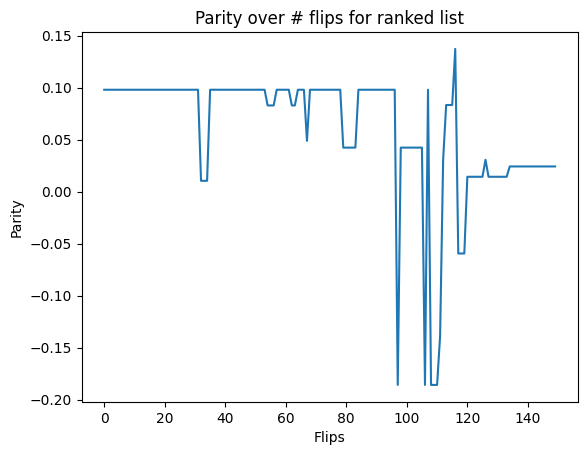

In [31]:
#Plot of the information in the order of the flips of parity
x=range(len(top_ranked_parity))

#Plot the data
plt.plot(x,top_ranked_parity)

#Add the labels
plt.xlabel('Flips')
plt.ylabel('Parity')
plt.title('Parity over # flips for ranked list')

#Show the plot
plt.show()

In [32]:
#Create a new dataframe with the original data for the random flipping
train_demo_df_random = pd.DataFrame(x_train, columns = predictors)
train_outcome_df_random = pd.DataFrame(y_train, columns = ['credit_risk'])
train_full_df_random = pd.concat([train_demo_df, train_outcome_df], axis=1)

In [33]:
#Randomized flipping
#Budget of 50
import random

random_list_flip = []
random_list_acc = []
random_list_parity = []

col_name = 'credit_risk'
budget = 150

#Loops through the budget and will randomly change rows in the dataframe based on the random library
#After changing the row it will calculate the accuracy and parity and then change the value back to its original value
#Follows the same flipping and calculations as before but this time it is with random rows rather than systematic flipping
for iter in range(budget):
    random_row = random.choice(train_full_df_random.index)
    if train_full_df_random.at[random_row,col_name] == 1:
        train_full_df_random.at[random_row,col_name] = 2

        accuracy, test_datapoints, test_prediction = decision_tree(train_full_df_random, predictors, target_var,'credit_risk_12')

        random_list_flip.append(iter)
        random_list_acc.append(accuracy)

        ##################################################################################
        parity = s_parity(test_datapoints, predictors, test_prediction, 'age', 45, 'credit_risk_12')
        random_list_parity.append(parity)

        #train_full_df.at[random_row,col_name] = 1

    elif train_full_df_random.at[random_row,col_name] == 2:
        train_full_df_random.at[random_row,col_name] = 1

        accuracy, test_datapoints, test_prediction = decision_tree(train_full_df_random, predictors, target_var,'credit_risk_12')
        random_list_flip.append(iter)
        random_list_acc.append(accuracy)

        ##################################################################################
        parity = s_parity(test_datapoints, predictors, test_prediction, 'age', 45, 'credit_risk_12')
        random_list_parity.append(parity)

        #train_full_df.at[random_row,col_name] = 2




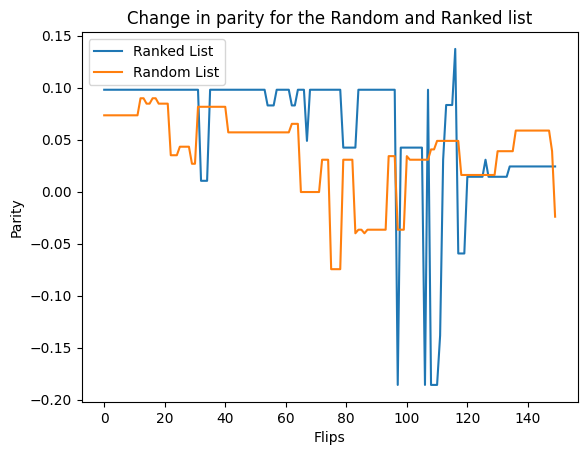

In [34]:
#Plotting the random flips dataset and the systematic flips
#Systematic flips will have 800
#Random will have 150

#Plot the first dataset which is the ranked data list with 800 flips
#list_parity.sort(reverse=True)
x=range(len(top_ranked_parity))
plt.plot(x,top_ranked_parity,label='Ranked List')

#Plot the second dataset which is the random list of 150 flips
x2 = range(len(random_list_parity))
plt.plot(x2,random_list_parity,label='Random List')

#Add the labels
plt.xlabel('Flips')
plt.ylabel('Parity')
plt.title('Change in parity for the Random and Ranked list')

#Add a legend
plt.legend()

#Show the plot
plt.show()


In [ ]:
#Getting the top 150 accuracy values
top_ranked_acc = ranked_acc[:150]
top_ranked_noABS_index = ranked_flip[:150]

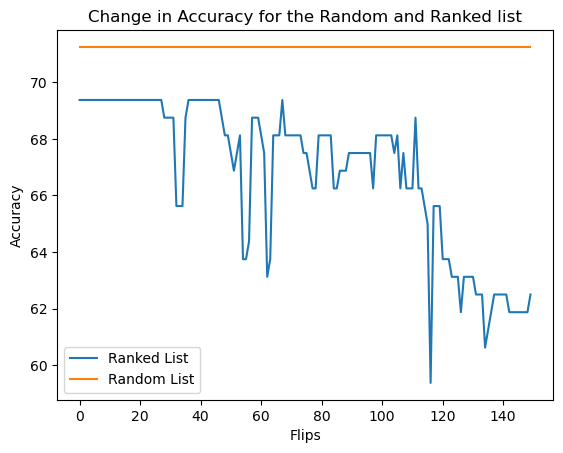

In [ ]:
#Plotting the random flips dataset and the systematic flips
#Systematic flips will have 800
#Random will have 150
#This is comparing the two accuracies

#Plot the first dataset which is the ranked data list with 800 flips
#list_parity.sort(reverse=True)
x=range(len(top_ranked_acc))
plt.plot(x,top_ranked_acc,label='Ranked List')

#Plot the second dataset which is the random list of 150 flips
x2 = range(len(random_list_acc))
plt.plot(x2,random_list_acc,label='Random List')

#Add the labels
plt.xlabel('Flips')
plt.ylabel('Accuracy')
plt.title('Change in Accuracy for the Random and Ranked list')

#Add a legend
plt.legend()

#Show the plot
plt.show()
